# Marketing Mix Models 

## The Basics


Marketing Mix Modeling (MMM or MMX) is a statistical analysis technique used to evaluate the impact of a company's marketing activities on sales (or any variable that wants to be measured). It relies in analysing historical data and typically fitting a model in which sales acts as a dependent variable.

MMM helps businesses understand the effectiveness of different marketing channels (such as TV, online ads, promotions, and pricing) and how they interact with each other. This insight allows companies to allocate their marketing budgets more efficiently, optimize their marketing strategies. MMM is particularly useful because it quantifies the return on investment (ROI) of marketing expenditures, enabling data-driven decision-making.

It's a highly demanded skill that can be applied in virtually, any industry. 


## Objective of this Notebook 

This notebook serves as a guide on how to build MM models in order to obtain contributions of the different channels (touchpoints) on product sales. This toy example includes relevant feature transformations as adstock (decay), seasonality, saturation, lags, etc. 

Likewise, it has been built with toy data which mimics real-life scenarios, but is not a full picture of the marketing spends a real product has during a year.

The basic application of these type of models uses a traditional linear model, however, it does have a few limitations that will be explored across the Notebook.

## 1. Imports and setup

In [1]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
import plotly.express as px
import numpy as np


import mmx.utils as utils

from mmx.linear import AdstockHyperTuning, add_adstock_to_pdf, sales_from, create_stack_df

In [2]:
# Set up 

# Configuration for viz and verbosity.
plt.rcParams["figure.figsize"] = (20, 8)

# Path were the input file is stored.
data_path = "../data/cough_and_cold_sales.csv"



## 2. EDA and basic transformations

Here we have synthetic weekly data of the sales of an off the counter **(OTC) cough and cold medicine** in a particular country. Along with the sales data, we have marketing spends for different channels that are typically relevant in the pharma industry. In this simple toy example we have a normalized monetary spend for tv, social media, medical crongresses, and trade (expenditure related to in-pharmacy display). We also have two external variables, the `stringency_index` which is related to the severness of COVID restrictions in this country, and the `flu_index` which is a variable monitored by the World Health Organization to track the intensity of the flu season in a particular region.  

Our objective is to determine the ROI of each of our mtk channels, to enable data-drive decision making for allocating our future marketing budget. 

In [3]:
# Define channels to use.
CHANNELS: list[str] = ['tv', 'social_media', 'congress', 'trade']
EXT_VARS: list[str] = ['flu_index', 'stringency_index'] 
# Define target variable.
TARGET = 'sales'
# Define weeks for testing period.
TEST_SIZE = 8
# Seed for reproducibility
SEED = 123456

In [4]:
# Load data
df = pd.read_csv(data_path, sep= ";", parse_dates=["date"])
df.head()

,date,stringency_index,sales,tv,social_media,congress,trade,flu_index
0,2019-01-13,0.0,0.88,0.95,0.47,0.0,0.88,0.33
1,2019-01-20,0.0,0.89,0.96,0.56,0.0,0.80,0.33
2,2019-01-27,0.0,0.82,0.90,0.55,0.0,0.88,0.33
3,2019-02-03,0.0,0.90,0.84,0.47,0.0,0.84,0.33
4,2019-02-10,0.0,0.88,0.78,0.48,0.0,0.83,0.33


In [5]:
# set date as index as it will make plotting easier
df.set_index("date", inplace=True)

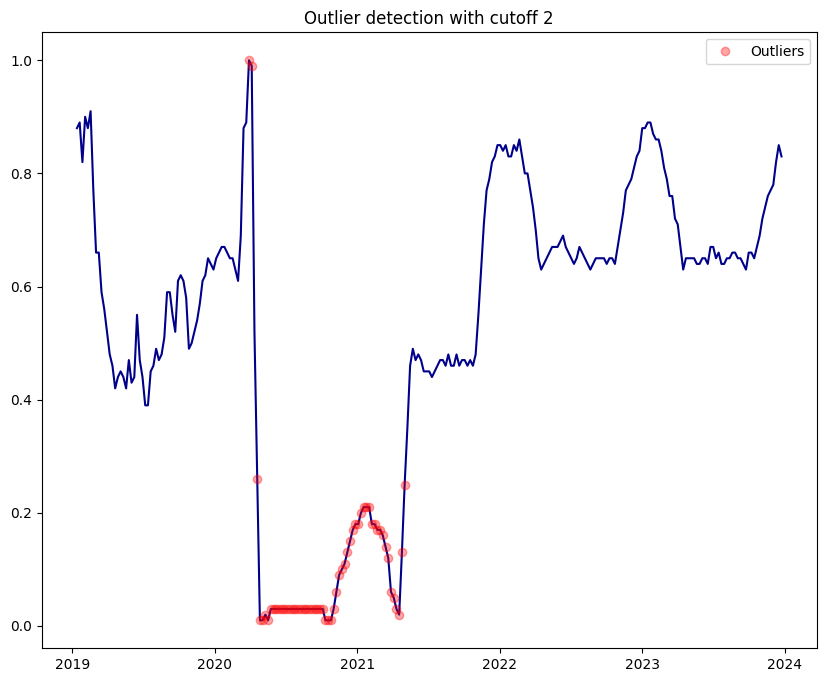

In [6]:
# Plot the target var and its Outliers
outlier_index = utils.plot_outliers_signal(
    df[TARGET], threshold=2
)
plt.show()



We have an evident abnormal event that happened in 2020 and 2021 that collapsed the sales. There's also a high spike in March 2020. This is of course, due to the pandemic, where there was a high "panic buying" spike, and later, a heavy drop in sales. 

What to do here?

Many people decide to leave out the pandemic years. However, the effects of COVID could still be felt up until early 2022, which leaves us with very little data for fitting our model. What's best depends on the use case, however, for this example, let's add a flag that resembles the effects of the pandemic.

In [7]:
# Adding a Covid flag
df['covid_flag'] = utils.add_flag(
    df,
    outlier_index.min(),
    outlier_index.max()
)

In [8]:
df.head(2) 

,stringency_index,sales,tv,social_media,congress,trade,flu_index,covid_flag
date,,,,,,,,
2019-01-13,0.0,0.88,0.95,0.47,0.0,0.88,0.33,0
2019-01-20,0.0,0.89,0.96,0.56,0.0,0.80,0.33,0


### Interactive plots

In [9]:
# Plot it
px.line(df.sales)

In [10]:
# PLot channel spend for month
fig = px.bar(
    df, 
    x=df.index, 
    y=CHANNELS, 
    title="Channel Spend per Date"
)
fig.show()

## 3. Adstock modeling.

In this section we add (i) carry over and (ii) saturation effects.

We want to model the relationship of the different investment channels using a linear regression, however we want to take into account the [decay effect](https://en.wikipedia.org/wiki/Advertising_adstock#Advertising_lag:_decay_effect) and the [law of diminishing returns](https://en.wikipedia.org/wiki/Advertising_adstock#Campaign_carry-over).

---
For this, instead of working directly with spend per channel, we apply different transformations to them

> 1. For carry over $c_{t}$, we apply the following transformation.
$$c_{t} = x_{t} + \sum_{j=1}^{n} \lambda^{t}  x_{t-j}$$
>
> Where $x_{t}$ is the investment in the channel for the $t$ period, $n$ represents the amount of periods to look back and $\lambda$ represents the strength of the decay factor. This means that investments made in time $t$ will have still an impact of the following weeks, and this effect will decay over time. Both $n$ and $\lambda$ will be parameters of the function.
><br/>
><br/>
>2. For the saturation effect $s_{t}$, the following transformation is applied.
>
>$$s_{t} =1 -  e^{-\alpha x_{t}} $$
>
> In this case, $\alpha$ will be a parameter to input.

<br/>

In consequence, instead of modeling sales as a function of investment per channel, we fit a regression to the transformations described previously. The question now is which values should we use for **$n$, $\lambda$ and $\alpha$**? We can think of them as *hyperparameters of our model*. And then perform a *numerical optimization* to find values that minimize the mean squared error (or any metric of our interest) of the model.
<br/>


Lastly, data presents a heavy seasonality, one hot encoded variables were added for every month in the year.

---

For a complete explanation of the methods used in here, we refer the reader to page *154/510* of [Introduction to Algorithmic Marketing](https://algorithmicweb.files.wordpress.com/2018/07/algorithmic-marketing-ai-for-marketing-operations-r1-7g.pdf).


## 4. Fit the model.

### Tune hyperparameters

- We use optuna for hyperparameter tuning, but other libraries like `scipy.minimize` or `sklearn` should work as well.
- For every channel, we have three ($\alpha$, $n$ and $\lambda$) hyperparameters to tune.
- We work with a traditional linear regression. -> prone to overfitting!!
- We aim to minimize *MSE*.
- We repeat 1 000 trials for the optimization, caution! can take some time. Feel free to change `n_trials=100` to speed things up.
- We split the dataset in train and test. Since we are working with time series we work with consecutives chunks of data.
- To do the optimization we use the `AdstockHyperTuning` class defined under `mmx.linear`. This class will optimize on alpha, decay and lag per each of the media channels. The best combination of them will be selected based on the lower *MSE*. 
- For the optimization, we need to pass a hyperparamater space, we do this with the `PARAMS_DICT` dictionary defined below. Here we pass the name of the parameter, a lower bound, an upper bound and whether we are expecting a float or an integer. For alpha and decay, we expect a float value, whilst lag should be an int.

In [11]:
# see description above.
PARAMS_DICT: dict = {  # channel: (lower_bound, upper_bound, type)
        "alpha_tv": (0, 0.1, "float"),  # floats
        'decay_tv': (0, 0.5, "float"),  # floats
        'lag_tv': (0, 6, "int"),  # int
        'alpha_social_media': (0, 0.1, "float"),
        'decay_social_media': (0, 0.5, "float"),
        'lag_social_media': (0, 6, "int"),
        'alpha_congress': (0, 0.1, "float"),
        'decay_congress': (0, 0.5, "float"),
        'lag_congress':  (0, 6, "int"),
        'alpha_trade': (0, 0.1, "float"),
        'decay_trade': (0, 0.5, "float"),
        'lag_trade': (0, 6, "int")
    }

In [12]:
# Split data for train test.
df_train = df.iloc[: -TEST_SIZE, :]
df_test = df.iloc[-TEST_SIZE:, :]

# Define features and target variable.
features = [
    c for c in list(df.columns) if 'flag' in c or 'index' in c
] + [f'adstock_{c}' for c in CHANNELS]



In [13]:
adstock_hypertuning = AdstockHyperTuning(
    df=df_train,
    hyperparameters=PARAMS_DICT,
    features=features,
    media_channels=CHANNELS,
    target=TARGET,
    n_trials=1_000,
)

tuned_params = adstock_hypertuning.hyperparam_tuning()

Optimization under way with 1000


### Run final model.
With tuned hyperparameters, we train the final model.

In [14]:
# Check optimized params.
tuned_params.best_params

{'alpha_tv': 0.007325410710173186,
 'decay_tv': 0.4721008148289741,
 'lag_tv': 6,
 'alpha_social_media': 0.035041019930881726,
 'decay_social_media': 0.2735965952834483,
 'lag_social_media': 0,
 'alpha_congress': 0.03134511920860169,
 'decay_congress': 0.4993626140928981,
 'lag_congress': 5,
 'alpha_trade': 0.0444600285642957,
 'decay_trade': 0.10685168164679842,
 'lag_trade': 5}

In [15]:
# Best set of hyperparameters.
hyperparameters = tuned_params.best_params

# We replicate adstock transformation, train test splitting and model fitting. 
# Add adstock columns. 
df_adstock_train  = add_adstock_to_pdf(df_train, hyperparameters, CHANNELS) 
df_adstock_test = add_adstock_to_pdf(df_test, hyperparameters, CHANNELS)

# Define train and test data.
X_train, y_train = df_adstock_train[features], df_adstock_train[TARGET]
X_test, y_test = df_adstock_test[features], df_adstock_test[TARGET]


adstock_hypertuning.model.fit(X_train, y_train)

LinearRegression()

## 5. Model performance.

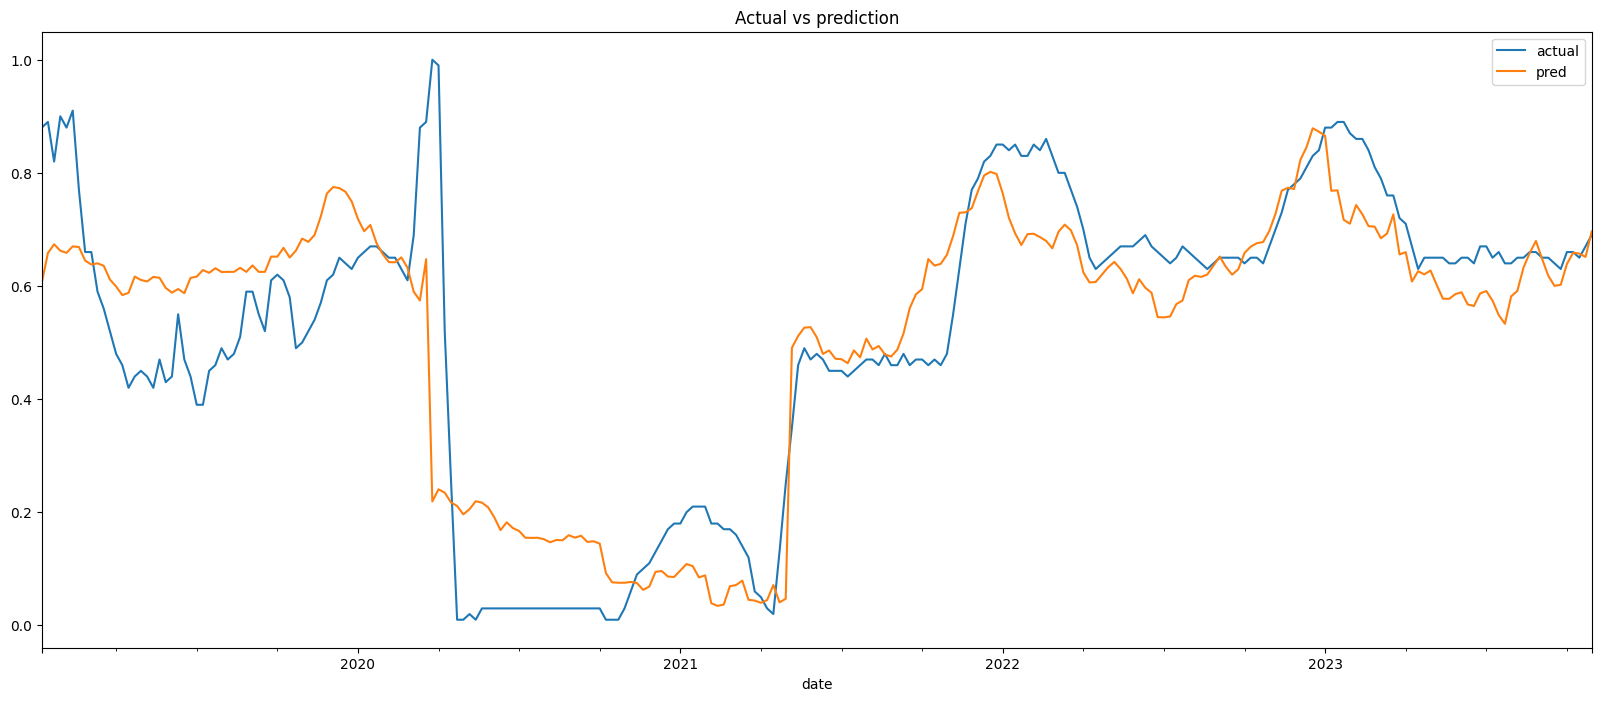

Training Performance
Performance Metrics:

MSE:0.017
R2: 0.763

Test Performance
Performance Metrics:

MSE:0.002
R2: -0.249



In [16]:
# Line chart for performance.

y_train.index = df_train.index  # adding index back for convenience

# Plot it
actual_vs_pred = pd.DataFrame(
    {
        "actual": y_train,
        "pred": adstock_hypertuning.model.predict(X_train),
       
    },
    index=df_train.index
)
actual_vs_pred.plot(title="Actual vs prediction")

plt.show()


print("Training Performance")
utils.performance_metrics(y_train, adstock_hypertuning.model.predict(X_train))

print("Test Performance")
utils.performance_metrics(y_test, adstock_hypertuning.model.predict(X_test))



## 6. Channel contribution.

Now with a fitted model, we can estimate the contribution of each channel. This tipically answers to the question: How much of a sales uplift (incremental sales) are attributed to the investments in a given channel. 

With this information, if we know how incremental sales we are getting, and how much a channel cost, we can then calculate the channel's ROI (return of investment).

We observe the marginal channel contribution and the return on investment per channel.



In [17]:

# base sales takes into account the intercept plus monthly effects.
base = (
    sum(
        [
            adstock_hypertuning.model.coef_[
                features.index(c)
            ] * X_train.iloc[:, features.index(c)]
            for c in features if 'adstock' not in c
        ]
    )
      + [adstock_hypertuning.model.intercept_] * len(df_train.index))

# Computation of contribution S = B + b1*C1 + b2*C2 
# Cnt_2 = (B+B1*C1+B2*C2) - (B+B1*C1) = B2*C2 


In [18]:
# create contribution plot
plot_df = create_stack_df(X_train, features, adstock_hypertuning.model)
# re adding base. 
base.name = "base"
plot_df = pd.concat([base, plot_df], axis=1)

In [19]:
px.area(
    plot_df,
    title="Contribution Painting"
)

In [20]:

# Compute ROI for every channel.
for c in features:
    if 'index' not in c and 'flag' not in c:
        channel_share = np.round(
            sum(
                sales_from(c, features, adstock_hypertuning.model, X_train)) / 
            sum(adstock_hypertuning.model.predict(X_train)
            ), 
        2)
        channel_roi = np.round(
            sum(
                sales_from(
                    c, features, adstock_hypertuning.model, X_train)) 
            / sum(df_adstock_train[c.replace('adstock_', '')]
            )
        ,2)
        print(f'For {c}: share of total sales is {channel_share} and ROI is {channel_roi}')

For adstock_tv: share of total sales is 0.16 and ROI is 0.16
For adstock_social_media: share of total sales is 0.12 and ROI is 0.14
For adstock_congress: share of total sales is 0.02 and ROI is 0.11
For adstock_trade: share of total sales is 0.06 and ROI is 0.05


In [21]:
px.bar(
        y=adstock_hypertuning.model.coef_,
        x=X_train.columns,
        title='Contribution bar plot',
        labels={
            "x": "Feature",
            "y": "Contribution"
        }
)


# Discussion 

- If there are some channel contributions negative? Does this make sense from a business POV? 
- What about seasonality? Shall we consider it?
- Would it be worth it to use another type of model, for example tree-based algorithms? or another type of linear model like Ridge?
- What recommendations would you give to business with these results

## Next steps. 

This analysis is powerful, but we can aim to do better. The state-of-the-art in Marketing Mix Models is using Bayesian Statistics to properly capture the attributions of each feature. You can see an example in the [`mmx_bayesian_model_example`](mmx_bayesian_model_example.ipynb) notebook.

